In [1]:
from google.colab import files
uploaded = files.upload()


Saving animal_dataset.zip to animal_dataset.zip


In [2]:
import zipfile
import io

zip_ref = zipfile.ZipFile(io.BytesIO(uploaded['animal_dataset.zip']), 'r')
zip_ref.extractall("/content/")
zip_ref.close()

DATASET_ROOT = "/content/animal_dataset"
print("Extracted folders:", DATASET_ROOT)


Extracted folders: /content/animal_dataset


In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [5]:
IMG_SIZE = (32, 32)

def load_images(root_dir):
    X, y = [], []
    class_names = []

    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        class_names.append(cls)
        label = len(class_names) - 1

        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            if not os.path.isfile(fpath):
                continue

            try:
                img = Image.open(fpath).convert("L")  # grayscale
                img = img.resize(IMG_SIZE)
                arr = np.array(img, dtype=np.float32) / 255.0
                X.append(arr.flatten())
                y.append(label)
            except Exception as e:
                print("Error loading:", fpath, e)

    return np.array(X), np.array(y), class_names


X, y, class_names = load_images(DATASET_ROOT)
print("Data shape:", X.shape)
print("Labels:", y.shape)
print("Classes:", class_names)


Data shape: (300, 1024)
Labels: (300,)
Classes: ['cat', 'dog', 'panda']


In [6]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_acc_l1 = []
mean_acc_l2 = []

for k in k_values:
    fold_l1 = []
    fold_l2 = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # L1: Manhattan
        model_l1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
        model_l1.fit(X_train, y_train)
        fold_l1.append(accuracy_score(y_val, model_l1.predict(X_val)))

        # L2: Euclidean
        model_l2 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        model_l2.fit(X_train, y_train)
        fold_l2.append(accuracy_score(y_val, model_l2.predict(X_val)))

    mean_acc_l1.append(np.mean(fold_l1))
    mean_acc_l2.append(np.mean(fold_l2))

print("L1 accuracy:", mean_acc_l1)
print("L2 accuracy:", mean_acc_l2)


L1 accuracy: [np.float64(0.36666666666666664), np.float64(0.4), np.float64(0.4), np.float64(0.4133333333333334), np.float64(0.39666666666666667), np.float64(0.42333333333333334), np.float64(0.43666666666666665), np.float64(0.42000000000000004)]
L2 accuracy: [np.float64(0.35), np.float64(0.3433333333333334), np.float64(0.36), np.float64(0.39), np.float64(0.4), np.float64(0.3933333333333333), np.float64(0.39999999999999997), np.float64(0.41000000000000003)]


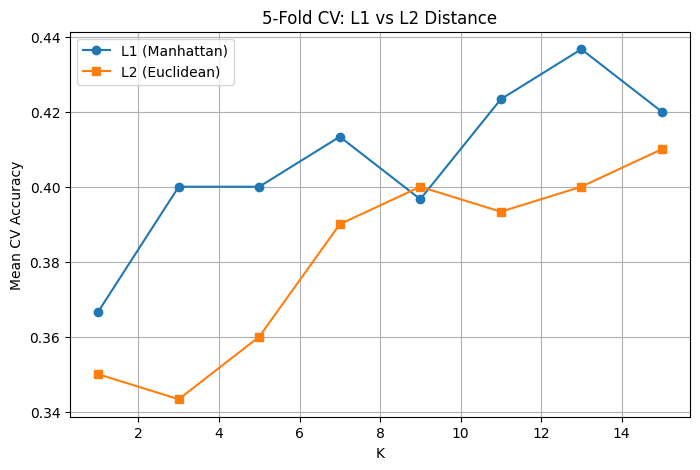

In [7]:
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_acc_l1, marker='o', label='L1 (Manhattan)')
plt.plot(k_values, mean_acc_l2, marker='s', label='L2 (Euclidean)')
plt.xlabel("K")
plt.ylabel("Mean CV Accuracy")
plt.title("5-Fold CV: L1 vs L2 Distance")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
best_acc = -1
best_k = None
best_metric = None

for metric, acc_list in [("L1", mean_acc_l1), ("L2", mean_acc_l2)]:
    for k, acc in zip(k_values, acc_list):
        if acc > best_acc:
            best_acc = acc
            best_k = k
            best_metric = metric

print(f"BEST → Metric: {best_metric}, K: {best_k}, Accuracy: {best_acc:.4f}")


BEST → Metric: L1, K: 13, Accuracy: 0.4367


In [9]:
metric_arg = 'manhattan' if best_metric == "L1" else 'euclidean'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

final_model = KNeighborsClassifier(n_neighbors=best_k, metric=metric_arg)
final_model.fit(X_train, y_train)

y_pred_test = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

print("Final Test Accuracy:", test_acc)


Final Test Accuracy: 0.45


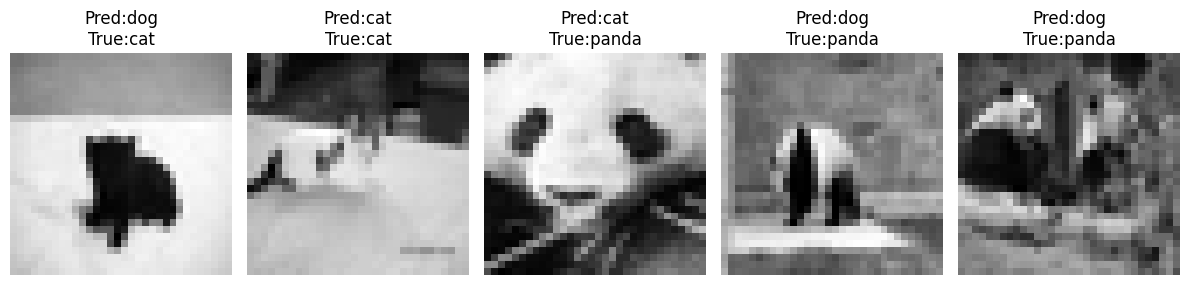

In [10]:
plt.figure(figsize=(12,3))
indices = np.arange(min(5, len(X_test)))

for i, idx in enumerate(indices):
    img = X_test[idx].reshape(32, 32)
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_test[idx]]

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred:{pred_label}\nTrue:{true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
